# Order parameters of Swarm Data

In [191]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import trackpy as tp
import copy as cp
from matplotlib import animation, rc

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as wd
from IPython.display import display, HTML

rc('text', usetex=True)
%matplotlib inline

In [192]:
Trayectories = pd.read_csv("//MAGNETIC/Antonio/RotatingMill/2018-01-22/Swarms.dat",sep='\t',index_col = 'frame')

C:\ProgramFiles\Anaconda3\envs\video\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [193]:
Center = pd.read_csv("//MAGNETIC/Antonio/RotatingMill/2018-01-22/Swarms_Center.dat",sep='\t',index_col = 'frame')

Once the trayectories are loaded, we must substract, from each frame, the position of the center in that frame. This yields the new fields of the Trayectory dataset, x0, and y0.

In [194]:
for i in Center.index:
    x0 = Center[Center.index==i].x
    y0 = Center[Center.index==i].y
    if i in Trayectories.index:
        Trayectories.loc[i,'x0'] = Trayectories.loc[i,'x']-x0
        Trayectories.loc[i,'y0'] = Trayectories.loc[i,'y']-y0

### Plot Trayectories. 

Here is what the superimposed trayectories look like. 

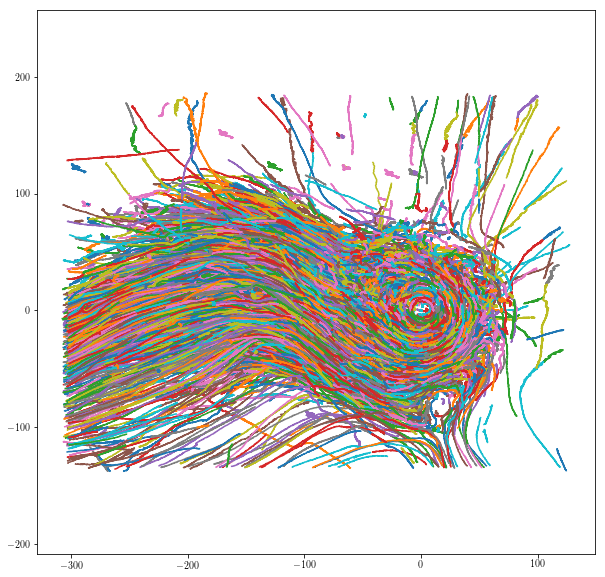

In [195]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.axis('equal')

for p in Trayectories.particle.unique():
    prt_ind = Trayectories.particle==p
    plt.plot(Trayectories[prt_ind].x0,Trayectories[prt_ind].y0)

And here is a video. 

In [196]:
def AnimateTrayectory(T):
    NumberOfFrames = T.index.max()

    fig, ax = plt.subplots(1,1,figsize=(10,10))
    Points = ax.plot(0,0,'o')
    Center = ax.plot(0,0,'o',color='red')
    plt.xlim([-300,100])
    plt.ylim([-150,200])
    plt.close()

    def init():
        Points[0].set_data([],[])
        Center[0].set_data([], [])
        return (Points,Center)

    def animate(i):
        fr_ind=(T.index==i)
        Points[0].set_data(T[fr_ind].x0,T[fr_ind].y0)
        Center[0].set_data(0,0)
        return (Points,Center)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                       frames=np.arange(0,NumberOfFrames,10), interval=20, blit=False)
    return anim

HTML(AnimateTrayectory(Trayectories).to_html5_video())

# Order Parameters

In order to later calculate the order parameters, we first calculate the particle velocities. This is done by iterating through each particle, and getting the differences in each trayectory. The last value of each trayectory is NaN.

In [197]:
Trayectories['r'] = np.sqrt(Trayectories.x0**2+Trayectories.y0**2)
Trayectories['phi'] = np.arctan2(Trayectories.y0,Trayectories.x0)

Trayectories['vr']=0
Trayectories['omg']=0
Trayectories['vth']=0

Trayectories['vx']=0
Trayectories['vy']=0

for i in Trayectories.particle.unique():
    location = Trayectories.particle==i
    Trayectories.loc[location,'vr'] = np.append(np.diff(Trayectories[location].r),np.NaN)
    Trayectories.loc[location,'omg'] = np.append(np.diff(np.unwrap(Trayectories[location].phi)),np.NaN)
    Trayectories.loc[location,'vx'] = np.append(np.diff(Trayectories[location].x0),np.NaN)
    Trayectories.loc[location,'vy'] = np.append(np.diff(Trayectories[location].y0),np.NaN)
    
Trayectories['vth'] = Trayectories['r']*Trayectories['omg']

The order parameters are given by: 
$$P =\left|\frac{\sum_i\vec{v}_i}{\sum_i\left|\vec{v}_i\right|}\right| $$
$$M =\left|\frac{\sum_i\vec{r}_i\times\vec{v}_i}{\sum_i\left|\vec{r}_i\right|\left|\vec{v}_i\right|}\right| $$

In [198]:
Order = Trayectories.filter(['frame','t'])

Order['vx'] = Trayectories['vx']
Order['vy'] = Trayectories['vy']

Order['rxv'] = Trayectories['vx']*Trayectories['y']-Trayectories['vy']*Trayectories['x']

Order['v_mag'] = np.sqrt(Trayectories['vx']**2 + Trayectories['vy']**2)
Order['rxv_mag'] = Trayectories['r'] * Order['v_mag']

$$P =\left|\frac{\sum_i\vec{v}_i}{\sum_i\left|\vec{v}_i\right|}\right| $$

$$P =\left|\frac{\sum_i v^x_i }{\sum_i\left|\vec{v}_i\right|}\hat{x}+\frac{\sum_i v^y_i}{\sum_i\left|\vec{v}_i\right|}\hat{y}\right| $$

$$P =
\sqrt{
\left(\frac{\sum_i v^x_i }{\sum_i\left|\vec{v}_i\right|}\right)^2 +
\left(\frac{\sum_i v^y_i}{\sum_i\left|\vec{v}_i\right|}\right)^2} $$

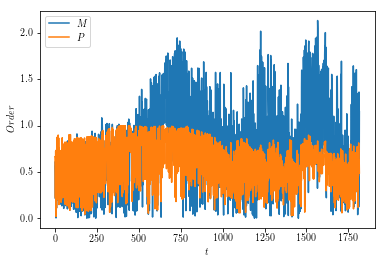

In [199]:
Sum = Order.groupby('t').sum();

Sum['M']=np.abs(Sum.rxv/Sum.rxv_mag)

Sum['P']=np.sqrt((Sum.vx/Sum.v_mag)**2 + (Sum.vy/Sum.v_mag)**2)

plt.plot(Sum.index,Sum.M);
plt.plot(Sum.index,Sum.P);
plt.xlabel('$t$')
plt.ylabel('$Order$')
plt.legend(['$M$','$P$'])

In [200]:
Sum_Filter = Sum.rolling(window=100,center=False).mean()

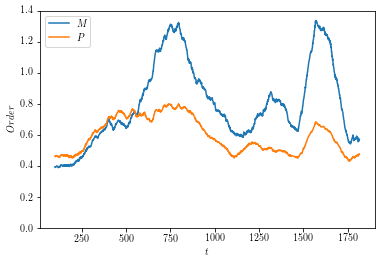

In [201]:
plt.plot(Sum_Filter.index,Sum_Filter.M);
plt.plot(Sum_Filter.index,Sum_Filter.P);
plt.xlabel('$t$')
plt.ylabel('$Order$')
plt.legend(['$M$','$P$'])
plt.ylim([0,1.4]);

# Filtering the Dataset to include less trayectories

In [202]:
Trayectories["v"] = np.sqrt(Trayectories.vx**2+Trayectories.vy**2)
Trayectories.head()

,t,x,y,particle,x0,y0,r,phi,vr,omg,vth,vx,vy,v
frame,,,,,,,,,,,,,,
0,0,413.318362,19.969447,0,116.653871,-118.760221,166.469564,-0.794345,0.264261,-0.001079,-0.179559,0.056812,-0.314481,0.319572
0,0,22.323842,31.709188,1,-274.340650,-107.020481,294.476103,-2.769649,-0.033341,0.000138,0.040697,0.045853,-0.025792,0.052609
0,0,316.664340,33.671175,2,19.999848,-105.058493,106.945224,-1.382679,0.018856,0.000324,0.034700,0.037619,-0.012027,0.039494
0,0,15.653823,41.318654,3,-281.010669,-97.411014,297.415369,-2.807910,-0.040241,0.000100,0.029626,0.047725,-0.014808,0.049970
0,0,209.981932,45.957319,4,-86.682559,-92.772350,126.966826,-2.322273,0.363160,-0.000159,-0.020237,-0.262764,-0.251497,0.363725


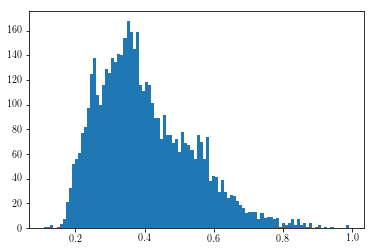

In [203]:
plt.hist(Trayectories.groupby('particle').mean().v,bins=100);

In [205]:
for i in Trayectories.particle.unique():
    location = Trayectories.particle==i
    Trayectories.loc[location,'vx0'] = np.append(np.diff(Trayectories[location].x),np.NaN)
    Trayectories.loc[location,'vy0'] = np.append(np.diff(Trayectories[location].y),np.NaN)

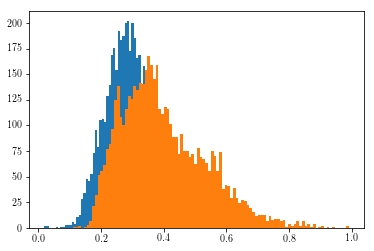

In [206]:
Trayectories["v0"] = np.sqrt(Trayectories.vx0**2+Trayectories.vy0**2)

plt.hist(Trayectories.groupby('particle').mean().v0,bins=100);
plt.hist(Trayectories.groupby('particle').mean().v,bins=100);


In [223]:
def FilterVelocities(T,threshold):
    T = cp.deepcopy(T)
    pass_part = np.where(T.groupby('particle').mean().v0>threshold)[0]
    return T[T.particle.isin(pass_part)]

T_Filtered = FilterVelocities(Trayectories,0.3)

In [224]:
HTML(AnimateTrayectory(T_Filtered).to_html5_video())

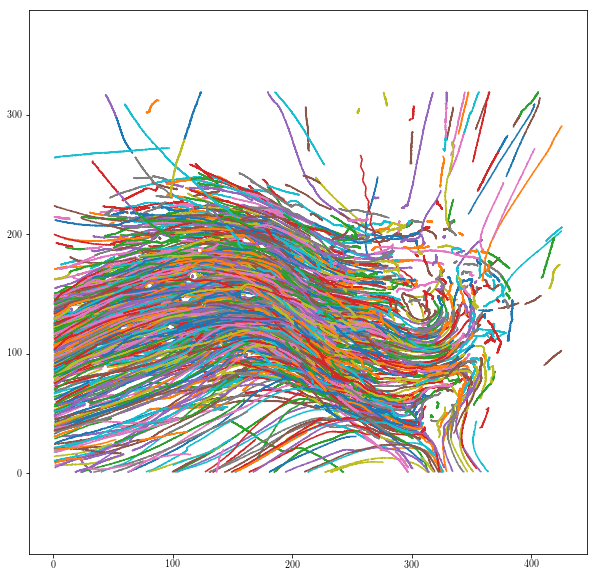

In [225]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.axis('equal')

for p in T_Filtered.particle.unique():
    prt_ind = T_Filtered.particle==p
    plt.plot(T_Filtered[prt_ind].x,T_Filtered[prt_ind].y)

This filtering doesnt seem to get rid of some of the constant points. Also, the biggest problem seems to be that the number and density of the particles is not constant. This means that at some point the number of particles is reduced in a specific region (namely close to the center), and this changes the order parameters. This can be seen in a large dip in the rotational parameter. 

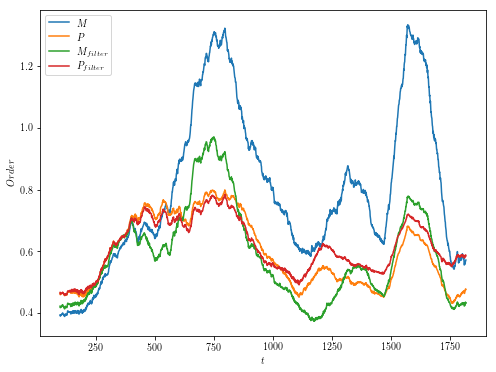

In [226]:
def CalculateOrderParameters(T):
    T = cp.deepcopy(T)
    
    T['rxv'] = T['vx']*T['y']-T['vy']*T['x']

    T['v_mag'] = np.sqrt(T['vx']**2 + T['vy']**2)
    
    T['rxv_mag'] = T['r'] * T['v_mag']

    Order = T.groupby('t').sum();

    Order['M']=np.abs(Order.rxv/Order.rxv_mag)

    Order['P']=np.sqrt((Order.vx/Order.v_mag)**2 + (Order.vy/Order.v_mag)**2)
    Order = Order.filter(["t","M","P"])
    return Order

Sum_Filter = CalculateOrderParameters(T_Filtered).rolling(window=100,center=False).mean()
Sum = CalculateOrderParameters(Trayectories).rolling(window=100,center=False).mean()

fig, ax1 = plt.subplots(1,1,figsize=[8,6])

ax1.plot(Sum.index,Sum.M);
ax1.plot(Sum.index,Sum.P);
ax1.plot(Sum_Filter.index,Sum_Filter.M);
ax1.plot(Sum_Filter.index,Sum_Filter.P);

plt.xlabel('$t$')
plt.ylabel('$Order$')
plt.legend(['$M$','$P$','$M_{filter}$','$P_{filter}$'])

I am going to have to try to improve the tracking